# A new restaurant in Rome

### Importing libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Importing neighbourhoods data

In [3]:
df_rome = pd.read_csv('https://github.com/roberto-brg/Coursera_Capstone/raw/master/Quartieri_Roma.csv')
df_rome

,Neighborhood,Latitude,Longitude
0,Q. I Flaminio,41.926306,12.469367
1,Q. II Parioli,41.922369,12.492369
2,Q. III Pinciano,41.912847,12.489208
3,Q. IV Salario,41.913928,12.500492
4,Q. V Nomentano,41.915061,12.517967
5,Q. VI Tiburtino,41.901092,12.526933
6,Q. VII Prenestino-Labicano,41.885200,12.538100
7,Q. VIII Tuscolano,41.869039,12.536472
8,Q. IX Appio-Latino,41.873400,12.516300
9,Q. X Ostiense,41.863650,12.478911


In [4]:
df_rome.shape

(35, 3)

In [5]:
address = 'Rome, IT'

geolocator = Nominatim(user_agent="rome_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Rome are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Rome are 41.8933203, 12.4829321.


### Visualizing data neighbourhoods on map

In [6]:
map_rome = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df_rome['Latitude'], df_rome['Longitude'], df_rome['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rome)  
    
map_rome

### Importing venues data from Foursquare

In [7]:
CLIENT_ID = '1I4432ZSH5SSAVU2T5OB2SA1QMFWTMMNNUN5KPRMJC5IGEWG' # Foursquare ID
CLIENT_SECRET = 'Q4CN4A0H5TMAOGQJWSHFMTCJCE5LKMBD2TWSVQKOCVOUOQ4N' #Foursquare Secret
VERSION = '20200523' # Foursquare API version
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1I4432ZSH5SSAVU2T5OB2SA1QMFWTMMNNUN5KPRMJC5IGEWG
CLIENT_SECRET:Q4CN4A0H5TMAOGQJWSHFMTCJCE5LKMBD2TWSVQKOCVOUOQ4N


In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
rome_venues = getNearbyVenues(names=df_rome['Neighborhood'],
                                   latitudes=df_rome['Latitude'],
                                   longitudes=df_rome['Longitude']
                                  )

Q. I Flaminio
Q. II Parioli
Q. III Pinciano
Q. IV Salario
Q. V Nomentano
Q. VI Tiburtino
Q. VII Prenestino-Labicano
Q. VIII Tuscolano
Q. IX Appio-Latino
Q. X Ostiense
Q. XI Portuense
Q. XII Gianicolense
Q. XIII Aurelio
Q. XIV Trionfale
Q. XV Della Vittoria
Q. XVI Monte Sacro
Q. XVII Trieste
Q. XVIII Tor di Quinto
Q. XIX Prenestino-Centocelle
Q. XX Ardeatino
Q. XXI Pietralata
Q. XXII Collatino
Q. XXIII Alessandrino
Q. XXIV Don Bosco
Q. XXV Appio Claudio
Q. XXVI Appio-Pignatelli
Q. XXVII Primavalle
Q. XXVIII Monte Sacro Alto
Q. XXIX Ponte Mammolo
Q. XXX San Basilio
Q. XXXI Giuliano-Dalmata
Q. XXXII Europa
Q. XXXIII Lido di Ostia Ponente
Q. XXXIV Lido di Ostia Levante
Q. XXXV Lido di Castel Fusano


In [10]:
print(rome_venues.shape)
rome_venues.head()

(1677, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Q. I Flaminio,41.926306,12.469367,20MQ Design e Caffè,41.925191,12.470467,Café
1,Q. I Flaminio,41.926306,12.469367,Tiepolo,41.924321,12.469223,Diner
2,Q. I Flaminio,41.926306,12.469367,MAXXI Museo Nazionale delle Arti del XXI Secolo,41.928455,12.466840,Art Museum
3,Q. I Flaminio,41.926306,12.469367,TreeBar,41.923152,12.471377,Cocktail Bar
4,Q. I Flaminio,41.926306,12.469367,Hotel Butterfly,41.927151,12.467478,Restaurant


In [11]:
rome_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Q. I Flaminio,78,78,78,78,78,78
Q. II Parioli,100,100,100,100,100,100
Q. III Pinciano,100,100,100,100,100,100
Q. IV Salario,100,100,100,100,100,100
Q. IX Appio-Latino,37,37,37,37,37,37
Q. V Nomentano,43,43,43,43,43,43
Q. VI Tiburtino,60,60,60,60,60,60
Q. VII Prenestino-Labicano,84,84,84,84,84,84
Q. VIII Tuscolano,68,68,68,68,68,68


In [12]:
print('There are {} uniques categories.'.format(len(rome_venues['Venue Category'].unique())))

There are 191 uniques categories.


### One-hot encoding

In [13]:
# one hot encoding
rome_onehot = pd.get_dummies(rome_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rome_onehot['Neighborhood'] = rome_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [rome_onehot.columns[-1]] + list(rome_onehot.columns[:-1])
rome_onehot = rome_onehot[fixed_columns]

rome_onehot.head()

,Neighborhood,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auditorium,BBQ Joint,Bagel Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo
0,Q. I Flaminio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Q. I Flaminio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Q. I Flaminio,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Q. I Flaminio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Q. I Flaminio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
rome_onehot.shape

(1677, 192)

In [15]:
rome_grouped = rome_onehot.groupby('Neighborhood').mean().reset_index()
rome_grouped

,Neighborhood,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auditorium,BBQ Joint,Bagel Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo
0,Q. I Flaminio,0.00000,0.00,0.000000,0.025641,0.000000,0.000000,0.012821,0.000000,0.012821,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
1,Q. II Parioli,0.00000,0.00,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01
2,Q. III Pinciano,0.01000,0.00,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01
3,Q. IV Salario,0.00000,0.00,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.00
4,Q. IX Appio-Latino,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.027027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,Q. V Nomentano,0.00000,0.00,0.000000,0.046512,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Q. VI Tiburtino,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
7,Q. VII Prenestino-Labicano,0.00000,0.00,0.011905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.011905,0.000000,0.000000,0.000000,0.000000,0.000000,0.011905,0.011905,0.000000,0.00
8,Q. VIII Tuscolano,0.00000,0.00,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.014706,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.00
9,Q. X Ostiense,0.00000,0.00,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.00


In [16]:
rome_grouped.shape

(35, 192)

### Most common venues in each neighbourhoods

In [17]:
num_top_venues = 5

for hood in rome_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = rome_grouped[rome_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Q. I Flaminio----
                venue  freq
0  Italian Restaurant  0.12
1                Café  0.08
2          Restaurant  0.05
3         Pizza Place  0.05
4               Hotel  0.04


----Q. II Parioli----
                venue  freq
0  Italian Restaurant  0.23
1               Hotel  0.11
2                Café  0.09
3  Seafood Restaurant  0.06
4               Plaza  0.06


----Q. III Pinciano----
                venue  freq
0               Hotel  0.24
1  Italian Restaurant  0.19
2               Plaza  0.06
3         Pizza Place  0.03
4      Ice Cream Shop  0.03


----Q. IV Salario----
                venue  freq
0  Italian Restaurant  0.25
1               Hotel  0.10
2         Pizza Place  0.09
3      Ice Cream Shop  0.09
4  Seafood Restaurant  0.03


----Q. IX Appio-Latino----
               venue  freq
0               Café  0.14
1     Ice Cream Shop  0.14
2       Dessert Shop  0.14
3        Pizza Place  0.08
4  Trattoria/Osteria  0.05


----Q. V Nomentano----
                

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = rome_grouped['Neighborhood']

for ind in np.arange(rome_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rome_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Q. I Flaminio,Italian Restaurant,Café,Pizza Place,Restaurant,Hotel,Pool,Diner,Cocktail Bar,Seafood Restaurant,Supermarket
1,Q. II Parioli,Italian Restaurant,Hotel,Café,Plaza,Seafood Restaurant,Pizza Place,Restaurant,Sandwich Place,Bakery,Sushi Restaurant
2,Q. III Pinciano,Hotel,Italian Restaurant,Plaza,Historic Site,Ice Cream Shop,Pizza Place,Park,Bistro,Trattoria/Osteria,Garden
3,Q. IV Salario,Italian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Plaza,Dessert Shop,Juice Bar,Park,Seafood Restaurant,Sushi Restaurant
4,Q. IX Appio-Latino,Dessert Shop,Ice Cream Shop,Café,Pizza Place,Restaurant,Bookstore,Trattoria/Osteria,Cupcake Shop,Park,Cocktail Bar
5,Q. V Nomentano,Italian Restaurant,Ice Cream Shop,Hotel,Park,Mediterranean Restaurant,Plaza,Art Museum,Cocktail Bar,Sushi Restaurant,Pizza Place
6,Q. VI Tiburtino,Italian Restaurant,Pub,Hotel,Supermarket,Pizza Place,Café,Plaza,Dessert Shop,Bar,Other Nightlife
7,Q. VII Prenestino-Labicano,Pizza Place,Italian Restaurant,Bakery,Café,Bus Station,Bar,Bistro,Ice Cream Shop,Plaza,Supermarket
8,Q. VIII Tuscolano,Pizza Place,Italian Restaurant,Ice Cream Shop,Pub,Café,Fast Food Restaurant,Plaza,Bar,Lounge,Restaurant
9,Q. X Ostiense,Italian Restaurant,Pizza Place,Café,Ice Cream Shop,Hotel,Nightclub,Pub,Cocktail Bar,Theater,Japanese Restaurant


### Elbow method

#### Let's create a function to evaluate the best number of k clusters with the elbow method

In [20]:
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(points.shape[0]):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += sum((points.loc[i, :] - curr_center).pow(2)) #+ (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [21]:
rome_grouped_clustering = rome_grouped.drop('Neighborhood', 1)
kmax = 10;
sse = calculate_WSS(rome_grouped_clustering, kmax)

Text(0, 0.5, 'SSE')

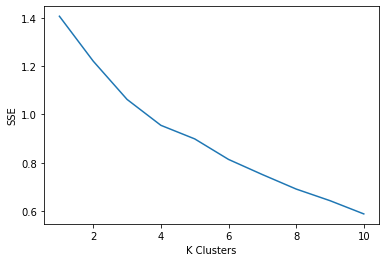

In [37]:
import matplotlib.pyplot as plt
plt.plot(range(1, kmax+1), sse);
plt.xlabel("K Clusters")
plt.ylabel("SSE")

### Silohuette method

In [23]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(rome_grouped_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(rome_grouped_clustering, labels, metric = 'euclidean'))

Text(0, 0.5, 'SIL')

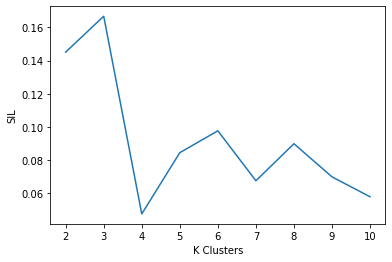

In [38]:
plt.plot(range(2, kmax+1), sil);
plt.xlabel("K Clusters")
plt.ylabel("SIL")

### Clustering with k = 6

In [25]:
# set number of clusters
kclusters = 6

rome_grouped_clustering = rome_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(rome_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 1, 1, 3, 1, 2, 2, 2, 2])

In [26]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

rome_merged = df_rome

# merge rome_grouped with df_rome to add latitude/longitude for each neighborhood
rome_merged = rome_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

rome_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Q. I Flaminio,41.926306,12.469367,Italian Restaurant,Café,Pizza Place,Restaurant,Hotel,Pool,Diner,Cocktail Bar,Seafood Restaurant,Supermarket,2
1,Q. II Parioli,41.922369,12.492369,Italian Restaurant,Hotel,Café,Plaza,Seafood Restaurant,Pizza Place,Restaurant,Sandwich Place,Bakery,Sushi Restaurant,1
2,Q. III Pinciano,41.912847,12.489208,Hotel,Italian Restaurant,Plaza,Historic Site,Ice Cream Shop,Pizza Place,Park,Bistro,Trattoria/Osteria,Garden,1
3,Q. IV Salario,41.913928,12.500492,Italian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Plaza,Dessert Shop,Juice Bar,Park,Seafood Restaurant,Sushi Restaurant,1
4,Q. V Nomentano,41.915061,12.517967,Italian Restaurant,Ice Cream Shop,Hotel,Park,Mediterranean Restaurant,Plaza,Art Museum,Cocktail Bar,Sushi Restaurant,Pizza Place,1


In [27]:
rome_merged

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Q. I Flaminio,41.926306,12.469367,Italian Restaurant,Café,Pizza Place,Restaurant,Hotel,Pool,Diner,Cocktail Bar,Seafood Restaurant,Supermarket,2
1,Q. II Parioli,41.922369,12.492369,Italian Restaurant,Hotel,Café,Plaza,Seafood Restaurant,Pizza Place,Restaurant,Sandwich Place,Bakery,Sushi Restaurant,1
2,Q. III Pinciano,41.912847,12.489208,Hotel,Italian Restaurant,Plaza,Historic Site,Ice Cream Shop,Pizza Place,Park,Bistro,Trattoria/Osteria,Garden,1
3,Q. IV Salario,41.913928,12.500492,Italian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Plaza,Dessert Shop,Juice Bar,Park,Seafood Restaurant,Sushi Restaurant,1
4,Q. V Nomentano,41.915061,12.517967,Italian Restaurant,Ice Cream Shop,Hotel,Park,Mediterranean Restaurant,Plaza,Art Museum,Cocktail Bar,Sushi Restaurant,Pizza Place,1
5,Q. VI Tiburtino,41.901092,12.526933,Italian Restaurant,Pub,Hotel,Supermarket,Pizza Place,Café,Plaza,Dessert Shop,Bar,Other Nightlife,2
6,Q. VII Prenestino-Labicano,41.885200,12.538100,Pizza Place,Italian Restaurant,Bakery,Café,Bus Station,Bar,Bistro,Ice Cream Shop,Plaza,Supermarket,2
7,Q. VIII Tuscolano,41.869039,12.536472,Pizza Place,Italian Restaurant,Ice Cream Shop,Pub,Café,Fast Food Restaurant,Plaza,Bar,Lounge,Restaurant,2
8,Q. IX Appio-Latino,41.873400,12.516300,Dessert Shop,Ice Cream Shop,Café,Pizza Place,Restaurant,Bookstore,Trattoria/Osteria,Cupcake Shop,Park,Cocktail Bar,3
9,Q. X Ostiense,41.863650,12.478911,Italian Restaurant,Pizza Place,Café,Ice Cream Shop,Hotel,Nightclub,Pub,Cocktail Bar,Theater,Japanese Restaurant,2


In [28]:
rome_merged.dropna(inplace = True)
rome_merged.reset_index(drop = True, inplace = True)
rome_merged['Cluster Labels'] = rome_merged['Cluster Labels'].astype(int)

In [29]:
rome_merged

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Q. I Flaminio,41.926306,12.469367,Italian Restaurant,Café,Pizza Place,Restaurant,Hotel,Pool,Diner,Cocktail Bar,Seafood Restaurant,Supermarket,2
1,Q. II Parioli,41.922369,12.492369,Italian Restaurant,Hotel,Café,Plaza,Seafood Restaurant,Pizza Place,Restaurant,Sandwich Place,Bakery,Sushi Restaurant,1
2,Q. III Pinciano,41.912847,12.489208,Hotel,Italian Restaurant,Plaza,Historic Site,Ice Cream Shop,Pizza Place,Park,Bistro,Trattoria/Osteria,Garden,1
3,Q. IV Salario,41.913928,12.500492,Italian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Plaza,Dessert Shop,Juice Bar,Park,Seafood Restaurant,Sushi Restaurant,1
4,Q. V Nomentano,41.915061,12.517967,Italian Restaurant,Ice Cream Shop,Hotel,Park,Mediterranean Restaurant,Plaza,Art Museum,Cocktail Bar,Sushi Restaurant,Pizza Place,1
5,Q. VI Tiburtino,41.901092,12.526933,Italian Restaurant,Pub,Hotel,Supermarket,Pizza Place,Café,Plaza,Dessert Shop,Bar,Other Nightlife,2
6,Q. VII Prenestino-Labicano,41.885200,12.538100,Pizza Place,Italian Restaurant,Bakery,Café,Bus Station,Bar,Bistro,Ice Cream Shop,Plaza,Supermarket,2
7,Q. VIII Tuscolano,41.869039,12.536472,Pizza Place,Italian Restaurant,Ice Cream Shop,Pub,Café,Fast Food Restaurant,Plaza,Bar,Lounge,Restaurant,2
8,Q. IX Appio-Latino,41.873400,12.516300,Dessert Shop,Ice Cream Shop,Café,Pizza Place,Restaurant,Bookstore,Trattoria/Osteria,Cupcake Shop,Park,Cocktail Bar,3
9,Q. X Ostiense,41.863650,12.478911,Italian Restaurant,Pizza Place,Café,Ice Cream Shop,Hotel,Nightclub,Pub,Cocktail Bar,Theater,Japanese Restaurant,2


### Visualizing results on map

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(rome_merged['Latitude'], rome_merged['Longitude'], rome_merged['Neighborhood'], rome_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results

#### Cluster 1 - Beaches

In [31]:
rome_merged.loc[rome_merged['Cluster Labels'] == 0]

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
32,Q. XXXIII Lido di Ostia Ponente,41.7401,12.2658,Beach,Pizza Place,Chinese Restaurant,Supermarket,Food & Drink Shop,Bakery,Candy Store,Pharmacy,Theater,Spa,0
34,Q. XXXV Lido di Castel Fusano,41.7170,12.3201,Beach,Italian Restaurant,Plaza,Martial Arts Dojo,Nightlife Spot,Surf Spot,Seafood Restaurant,Pier,Metro Station,Nightclub,0


#### Cluster 2 - Italian restaurants and hotels (centre-north of Rome)

In [32]:
rome_merged.loc[rome_merged['Cluster Labels'] == 1]

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,Q. II Parioli,41.922369,12.492369,Italian Restaurant,Hotel,Café,Plaza,Seafood Restaurant,Pizza Place,Restaurant,Sandwich Place,Bakery,Sushi Restaurant,1
2,Q. III Pinciano,41.912847,12.489208,Hotel,Italian Restaurant,Plaza,Historic Site,Ice Cream Shop,Pizza Place,Park,Bistro,Trattoria/Osteria,Garden,1
3,Q. IV Salario,41.913928,12.500492,Italian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Plaza,Dessert Shop,Juice Bar,Park,Seafood Restaurant,Sushi Restaurant,1
4,Q. V Nomentano,41.915061,12.517967,Italian Restaurant,Ice Cream Shop,Hotel,Park,Mediterranean Restaurant,Plaza,Art Museum,Cocktail Bar,Sushi Restaurant,Pizza Place,1
13,Q. XIV Trionfale,41.923206,12.437933,Italian Restaurant,Hotel,Plaza,Pizza Place,Café,Gym,Gym / Fitness Center,Coffee Shop,Cocktail Bar,Department Store,1
17,Q. XVIII Tor di Quinto,41.945186,12.476983,Italian Restaurant,Café,Restaurant,Basketball Court,Cocktail Bar,Sandwich Place,Steakhouse,Hotel,Gym / Fitness Center,Food Truck,1


#### Cluster 3 - Italian restaurants and pizza places

In [33]:
rome_merged.loc[rome_merged['Cluster Labels'] == 2]

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Q. I Flaminio,41.926306,12.469367,Italian Restaurant,Café,Pizza Place,Restaurant,Hotel,Pool,Diner,Cocktail Bar,Seafood Restaurant,Supermarket,2
5,Q. VI Tiburtino,41.901092,12.526933,Italian Restaurant,Pub,Hotel,Supermarket,Pizza Place,Café,Plaza,Dessert Shop,Bar,Other Nightlife,2
6,Q. VII Prenestino-Labicano,41.885200,12.538100,Pizza Place,Italian Restaurant,Bakery,Café,Bus Station,Bar,Bistro,Ice Cream Shop,Plaza,Supermarket,2
7,Q. VIII Tuscolano,41.869039,12.536472,Pizza Place,Italian Restaurant,Ice Cream Shop,Pub,Café,Fast Food Restaurant,Plaza,Bar,Lounge,Restaurant,2
9,Q. X Ostiense,41.863650,12.478911,Italian Restaurant,Pizza Place,Café,Ice Cream Shop,Hotel,Nightclub,Pub,Cocktail Bar,Theater,Japanese Restaurant,2
11,Q. XII Gianicolense,41.872856,12.443978,Pizza Place,Italian Restaurant,Café,Ice Cream Shop,Pub,Mediterranean Restaurant,Plaza,Restaurant,Supermarket,Seafood Restaurant,2
14,Q. XV Della Vittoria,41.930147,12.456694,Italian Restaurant,Stadium,Nightclub,Café,Pool,Restaurant,Gym / Fitness Center,Bakery,Tennis Court,Pizza Place,2
15,Q. XVI Monte Sacro,41.943633,12.530317,Plaza,Café,Hotel,Japanese Restaurant,Italian Restaurant,Chinese Restaurant,Pizza Place,Gastropub,Park,French Restaurant,2
16,Q. XVII Trieste,41.925931,12.513392,Café,Italian Restaurant,Dessert Shop,Hotel,Ice Cream Shop,Plaza,Pizza Place,Bar,Burger Joint,Cocktail Bar,2
18,Q. XIX Prenestino-Centocelle,41.884111,12.566939,Pizza Place,Wine Bar,Italian Restaurant,Plaza,Burger Joint,Chinese Restaurant,Shopping Mall,Steakhouse,Multiplex,Café,2


#### Cluster 4 - Cafés

In [34]:
rome_merged.loc[rome_merged['Cluster Labels'] == 3]

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
8,Q. IX Appio-Latino,41.873400,12.516300,Dessert Shop,Ice Cream Shop,Café,Pizza Place,Restaurant,Bookstore,Trattoria/Osteria,Cupcake Shop,Park,Cocktail Bar,3
10,Q. XI Portuense,41.855239,12.452900,Café,Park,Pizza Place,Italian Restaurant,Supermarket,Gym / Fitness Center,Plaza,Burger Joint,Soccer Stadium,Soccer Field,3
12,Q. XIII Aurelio,41.896700,12.441100,Hotel,Italian Restaurant,Café,Park,Fast Food Restaurant,Pub,Chinese Restaurant,Ice Cream Shop,Breakfast Spot,Restaurant,3
19,Q. XX Ardeatino,41.844800,12.503400,Café,Italian Restaurant,Park,Fast Food Restaurant,Sporting Goods Shop,Hotel,Plaza,Supermarket,Gas Station,Gym Pool,3
20,Q. XXI Pietralata,41.915381,12.555589,Supermarket,Park,Pizza Place,Café,Metro Station,Gym,Gym Pool,Skating Rink,Hotel,Bus Station,3
21,Q. XXII Collatino,41.903750,12.554889,Café,Pizza Place,Supermarket,Gym,Restaurant,Gym Pool,Plaza,Food & Drink Shop,Pharmacy,Food Truck,3
26,Q. XXVII Primavalle,41.925781,12.416097,Café,Argentinian Restaurant,Gym,Pizza Place,Hotel,Pub,Train Station,Movie Theater,Peruvian Restaurant,Supermarket,3
27,Q. XXVIII Monte Sacro Alto,41.947642,12.554125,Café,Clothing Store,Supermarket,Plaza,Pizza Place,Basketball Stadium,Electronics Store,Boutique,Sushi Restaurant,Shoe Store,3
28,Q. XXIX Ponte Mammolo,41.937664,12.566011,Café,Hotel,Italian Restaurant,Pizza Place,Restaurant,Grocery Store,Gym,Food & Drink Shop,Beer Garden,Basketball Stadium,3
29,Q. XXX San Basilio,41.946078,12.581075,Hotel,Hotel Bar,Pharmacy,Gym,Gym / Fitness Center,Gym Pool,Café,Pizza Place,Soccer Stadium,Tennis Court,3


#### Cluster 5 - Hotels and Italian restaurants in the suburbs of Rome

In [35]:
rome_merged.loc[rome_merged['Cluster Labels'] == 4]

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
30,Q. XXXI Giuliano-Dalmata,41.816314,12.499878,Hotel,Italian Restaurant,Pub,Plaza,Park,Soccer Field,Zoo,Food Court,Furniture / Home Store,Friterie,4


#### Cluster 6 - Hotel and steakhouses

In [36]:
rome_merged.loc[rome_merged['Cluster Labels'] == 5]

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
24,Q. XXV Appio Claudio,41.8419,12.5593,Hotel,Café,Food & Drink Shop,Steakhouse,Supermarket,Park,Tennis Court,Football Stadium,Cuban Restaurant,Burger Joint,5
25,Q. XXVI Appio-Pignatelli,41.8414,12.5424,Steakhouse,Hotel,Bed & Breakfast,Food & Drink Shop,Tennis Court,Pizza Place,Martial Arts Dojo,Supermarket,Italian Restaurant,Café,5
